In [59]:
import pandas as pd
import numpy as np
import pywikibot

import datetime as dt
import time
import matplotlib.pyplot as plt

import requests
from bs4 import BeautifulSoup
import re
from string import ascii_uppercase as auc

import sys
sys.path.append('..')
from helpers import *
import get_batches
from importlib import reload

from itertools import cycle

In [2]:
## LOAD DATA ON ALL WIKIPEDIA
df = pd.read_csv('wiki_data_all.csv', index_col=0)

for t in ['5', '15', '30', '60']:
    with open(f'batches_{t}.npy', 'rb') as f:
        batches = np.load(f, allow_pickle=True)
        df_batches = pd.DataFrame(batches, columns=['revid', f'batchid_{t}'])
        df_batches['revid'] = df_batches['revid'].astype(int)
    
    df = df.set_index('revid').join(df_batches.set_index('revid')).reset_index()
    df[f'batchid_{t}'] = df[f'batchid_{t}'].fillna(df.revid)

In [3]:
df['time'] = df.timestamp.apply(lambda t: dt.datetime.strptime(t, '%Y-%m-%d %H:%M:%S').timestamp())

In [4]:
df.head()

,revid,user,userid,userhidden,timestamp,anon,commenthidden,page,pageid,batchid_5,batchid_15,batchid_30,batchid_60,time
0,1063058808,Reywas92,1233313.0,False,2022-01-01 00:00:00,False,False,Betty_White,415045,1063058808,1063058808,1063058808,1063058808,1.641013e+09
1,1063058809,99.237.103.147,0.0,False,2022-01-01 00:00:00,True,False,ARM_Cortex-A78,64280898,1063058809,1063058809,1063058809,1063058809,1.641013e+09
2,1063058810,Dmoore5556,29278485.0,False,2022-01-01 00:00:01,False,False,2021_Cotton_Bowl_Classic,67976697,1063058810,1063058810,1063058810,1063058810,1.641013e+09
3,1063058811,Extraordinary Writ,39795743.0,False,2022-01-01 00:00:00,False,False,Francis_Moorehouse,34931769,1063058811,1063058811,1063058811,1063058811,1.641013e+09
4,1063058812,Twozenhauer,14955567.0,False,2022-01-01 00:00:01,False,False,Trouble_(1931_film),69644588,1063058812,1063058812,1063058812,1063058812,1.641013e+09


In [5]:
df['is_bot'] = df.user.astype(str).str.lower().apply(lambda s: s.find('bot') > 0)

In [6]:
t_min, t_max = df.timestamp.min(), df.timestamp.max()
t_min, t_max

('2022-01-01 00:00:00', '2022-02-01 00:00:00')

In [7]:
df_nonbot = df[~df.is_bot]

g = df_nonbot.groupby('batchid_5').pageid.nunique()
pct_5 = df_nonbot[df_nonbot.batchid_5.isin(g[g>1].index)].shape[0] / df_nonbot.shape[0]

g = df_nonbot.groupby('batchid_15').pageid.nunique()
pct_15 = df_nonbot[df_nonbot.batchid_15.isin(g[g>1].index)].shape[0] / df_nonbot.shape[0]

g = df_nonbot[~df_nonbot.is_bot].groupby('batchid_30').pageid.nunique()
pct_30 = df_nonbot[df_nonbot.batchid_30.isin(g[g>1].index)].shape[0] / df_nonbot.shape[0]

g = df_nonbot[~df_nonbot.is_bot].groupby('batchid_60').pageid.nunique()
pct_60 = df_nonbot[df_nonbot.batchid_60.isin(g[g>1].index)].shape[0] / df_nonbot.shape[0]

In [8]:
pct_5, pct_15, pct_30, pct_60

(0.4907455654888605,
 0.6122457783453952,
 0.6645117071094082,
 0.7017948063005535)

In [9]:
def test_random_pairs(df, I):
    revs = df['user'].unique()
    n_samples = 10000

    n_w_batch = 0
    for i in range(n_samples):
        if i%1000 == 0:
            print(f'Completed {i} iterations.')
        pair = np.random.choice(revs, 2, replace=False)
        assert(pair[0] != pair[1])
        d1 = df[df.user == pair[0]]
        d2 = df[df.user == pair[1]]
        
        for t1,t2 in itertools.product(d1.time, d2.time):
            if np.abs(t1 - t2) <= I:
                n_w_batch += 1
                break
                        
    return 1.*n_w_batch / n_samples

In [10]:
%%time
# test_random_pairs(df_nonbot, 5*60)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 5.25 µs


In [11]:
g = df.groupby('user').pageid.nunique()

In [12]:
n_revisions = df.shape[0]
n_users = len(g)
pct_multiple_page_edits = len(g[g>1]) / len(g)
pct_anon = df[df.anon].shape[0] / n_revisions
pct_revisions_multi = g[g>1].sum() / g.sum()

n_revisions, n_users, pct_multiple_page_edits*100, pct_anon * 100, pct_revisions_multi * 100

(4025914, 359919, 25.127320313737258, 17.8706748330938, 88.80258119739803)

In [13]:
g = df_nonbot.groupby('user').pageid.nunique()

In [14]:
n_revisions = df_nonbot.shape[0]
n_users = len(g)
pct_multiple_page_edits = len(g[g>1]) / len(g)
pct_anon = df_nonbot[df_nonbot.anon].shape[0] / n_revisions
pct_revisions_multi = g[g>1].sum() / g.sum()

n_revisions, n_users, pct_multiple_page_edits*100, pct_anon * 100, pct_revisions_multi * 100

(3523500, 359719, 25.11349136409253, 20.418844898538385, 86.01089087932998)

## Run experiments on math pages

In [15]:
BASE_MATH_URL = 'https://en.wikipedia.org/wiki/Wikipedia:WikiProject_Mathematics/List_of_mathematics_articles'

def get_all_math_articles():
    all_pages = df.page.unique()
    
    math_pages = []

    for i in auc:
        page = requests.get(f'{BASE_MATH_URL}_({i})') 
        soup = BeautifulSoup(page.content, 'html.parser') 
        
        links = soup.select("a[href*=\/wiki\/]")



        for link in links:
#             title = link.get('title')
            href = link.get('href')
            if match := re.search('\/wiki\/(.+)', href, re.IGNORECASE):
                page = match.group(1)
                if page is not None and page not in ['Privacy_policy']:
                    math_pages += [page]
        
        return math_pages

math_pages = np.unique(get_all_math_articles())
math_df = df[df.page.isin(math_pages) & (~df.user.isin(['Citation bot', 'WikiCleanerBot', 'AnomieBOT']))]
math_df = math_df[~math_df.is_bot].reset_index(drop=True)


sum(math_df.groupby(['user'])['page'].nunique() > 1), math_df.user.nunique()

(52, 351)

In [16]:
SITE = pywikibot.Site('en', 'wikipedia')
cat = pywikibot.Category(SITE, '21st-century_American_politicians')
pol_pages = [p.pageid for p in cat.articles()]

In [17]:
sub_pages = [[(s.pageid, a.pageid) for a in s.articles()] for s in cat.subcategories()]

In [18]:
df_cat = df[df.pageid.isin(pol_pages) & ~df.is_bot].reset_index(drop=True) 

# df_subcat = pd.DataFrame(get_batches.flatten(sub_pages), columns=['subcatid', 'pageid'])
# df_cat = pd.merge(df_subcat, df_cat, on='pageid')

In [19]:
df_cat.shape

(13430, 15)

In [20]:
reload(get_batches)

<module 'get_batches' from '/Users/akgoldbe/Dropbox/My Mac (MacBook-Air)/Documents/CMU/research/timing/batching-privacy/wiki_analysis/get_batches.py'>

In [21]:
df_cat['dt_timestamp'] = df_cat.timestamp.apply(lambda t: dt.datetime.strptime(t, '%Y-%m-%d %H:%M:%S'))
df_cat['time'] = df_cat.dt_timestamp.apply(lambda t: t.timestamp())
df_g = df_cat.groupby('user')[['revid', 'dt_timestamp']]

In [22]:
#### Get the subsequent review after each

In [23]:
df_cat = df_cat.sort_values(by = 'time').reset_index()

In [24]:
# split one week train, three weeks test
train_test_split = dt.datetime.strptime(t_min, '%Y-%m-%d %H:%M:%S') + dt.timedelta(days=7)
df_cat_train = df_cat[df_cat.dt_timestamp <= train_test_split]
df_cat_test = df_cat[df_cat.dt_timestamp > train_test_split]
df_cat_train.shape[0], df_cat_test.shape[0]

(3068, 10362)

In [25]:
def get_batches_consecutive(df_cat, time_col='time', subcat=False):
    if subcat:
        batches = df_cat_train.groupby('subcatid').apply(lambda l: apply_batches_consecutive(r, time_col))
        n = sum([b[0] for b in batches])
        n_batch = sum([b[1] for b in batches])
        n, n_batch

        d_batch = np.array(get_batches.flatten([b[2] for b in batches]))
        d_no_batch = np.array(get_batches.flatten([b[3] for b in batches]))

        return n, n_batch, np.array(d_batch), np.array(d_no_batch)
    else:
        return apply_batches_consecutive(df_cat, time_col)
    
def apply_batches_consecutive(df_cat, time_col):
    df_cat = df_cat.sort_values(by=time_col).reset_index(drop=True)
    t_last = None
    pageid_last = None
    user_last = None
    n = 0
    n_batch = 0
    d_batch = []
    d_no_batch = []
    for i in range(df_cat.shape[0]):
        if t_last is not None:
            t = df_cat.iloc[i][time_col]
            pageid = df_cat.iloc[i].pageid
            user = df_cat.iloc[i].user
            if pageid != pageid_last:
                n+=1
                if user == user_last:
                    n_batch += 1
                    d_batch += [t - t_last]
                else:
                    d_no_batch += [t - t_last]
        t_last = df_cat.iloc[i][time_col]
        pageid_last = df_cat.iloc[i].pageid
        user_last = df_cat.iloc[i].user
    
    return n, n_batch, d_batch, d_no_batch

def get_prec_recall(d_batch, d_no_batch, Ts=np.arange(10, 1000, 10)):
    n_TP, n_FP, n_TN, n_FN = [], [], [], []
    for T in Ts:
        n_TP += [sum(d_batch <= T)]
        n_FP += [sum(d_no_batch <= T)]
        n_TN += [sum(d_no_batch > T)]
        n_FN += [sum(d_batch > T)]

    fdr = np.array(n_FP) / (np.array(n_FP) + np.array(n_TP))
    precision = 1. - fdr
    precision = np.array([max(precision[i:]) for i in range(len(precision))])
    recall = np.array(n_TP) / (np.array(n_TP) + np.array(n_FN))
    return precision, recall

In [417]:
n, n_batch, d_batch, d_no_batch = get_batches_consecutive(df_cat_train)

In [27]:
g_batch = np.percentile(d_batch, [10, 25, 50, 75, 95])
g_batch

array([ 14.7,  30. ,  42. ,  83. , 375.3])

In [420]:
(np.array(d_batch) <= 300).sum()

511

In [421]:
n, n_batch, d_batch, d_no_batch = get_batches_consecutive(df_cat)

In [422]:
len(d_no_batch)

9101

In [423]:
len(d_batch)

1888

In [425]:
(np.array(d_batch) <= 300).sum()

1739

In [426]:
res_no_priv

([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 array([0.82512537, 0.82512537, 0.81617825, 0.81199921, 0.80926255,
        0.80281769, 0.80222776, 0.80160948, 0.7981202 , 0.79583372,
        0.75288839, 0.38386163, 0.2382553 , 0.17073276, 0.13453869,
        0.11671609, 0.10290367, 0.06483388]),
 array([0.04877411, 0.16853818, 0.2903165 , 0.40561314, 0.51305008,
        0.61002212, 0.69912871, 0.78434137, 0.85753496, 0.9462202 ,
        0.04877411, 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        ]))

In [405]:
def sample_users(df, r=0.1):
    users=df.user.unique()
    S_users = np.random.choice(users, round(r*len(users)), replace=False)
    return df[df.user.isin(S_users)]

n_iters = 5
d_no_batch = [get_batches_consecutive(sample_users(df_cat_train))[3] for i in range(n_iters)]

gs = sum([np.percentile(d, [10, 25, 50, 75, 95]) for d in d_no_batch]) / n_iters
gs

array([  193.16,   654.5 ,  1951.9 ,  4712.4 , 14145.37])

In [29]:
## Prepare test data to add noise to

# with 5 mins can capture 50% of all instances of batching in this set
df_batches = df_cat_test.groupby('user')[['revid', 'dt_timestamp']].apply(get_batches.get_batches)
df_batches.revid = df_batches.revid.astype(int)
df_cat_test = df_cat_test.set_index('revid').join(df_batches.set_index('revid')).reset_index()
g = df_cat_test.groupby('batchid').pageid.nunique()
df_cat_test['is_batched'] = df_cat_test.batchid.apply(lambda b: b in g[g>1].index)

# dedupe multiple revisions on same page by setting to latest revision on that page
dedupe = df_cat_test.groupby(['batchid', 'pageid']).timestamp.max()
df_cat_test = pd.merge(df_cat_test, dedupe.reset_index(), on=['batchid', 'pageid', 'timestamp'])

# get first batches
first_batch = df_cat_test.groupby('batchid').dt_timestamp.min().reset_index()
first_batch['is_first'] = True
df_cat_test = pd.merge(df_cat_test, first_batch, how='left', on=['batchid', 'dt_timestamp'])
df_cat_test['is_nonfirst_batch'] = df_cat_test.apply(lambda r: r.is_batched and np.isnan(r.is_first), axis=1)

In [30]:
df_cat_test.head()

,revid,index,user,userid,userhidden,timestamp,anon,commenthidden,page,pageid,...,batchid_15,batchid_30,batchid_60,time,is_bot,dt_timestamp,batchid,is_batched,is_first,is_nonfirst_batch
0,1064361543,3068,Rlink2,42425010.0,False,2022-01-08 00:01:11,False,False,Linda_Stender,1611832,...,1064345919,1064325109,1064325109,1.641600e+09,False,2022-01-08 00:01:11,1064361543,False,True,False
1,1064363594,3069,PerpetuityGrat,41302477.0,False,2022-01-08 00:17:35,False,False,Jeanette_Taylor,60411244,...,1064363594,1064363594,1064363594,1.641601e+09,False,2022-01-08 00:17:35,1064363594,False,True,False
2,1064365160,3070,Rlink2,42425010.0,False,2022-01-08 00:29:26,False,False,Jay_Roberts,44213633,...,1064345919,1064325109,1064325109,1.641602e+09,False,2022-01-08 00:29:26,1064365160,False,True,False
3,1064366335,3071,Rlink2,42425010.0,False,2022-01-08 00:36:33,False,False,Sam_Liccardo,41156577,...,1064345919,1064325109,1064325109,1.641602e+09,False,2022-01-08 00:36:33,1064366335,True,True,False
4,1064366339,3072,Muboshgu,602857.0,False,2022-01-08 00:36:26,False,False,Ted_Cruz,2500271,...,1064366339,1064366339,1064366339,1.641602e+09,False,2022-01-08 00:36:26,1064366339,False,True,False


In [31]:
P_vals = [25, 50, 75, 95]
eps_vals = [0.1, 0.5, 1., 2.]

In [121]:
df_cross.head()

,revid_x,index_x,user_x,userid_x,userhidden_x,timestamp_x,anon_x,commenthidden_x,page_x,pageid_x,...,batchid_30_y,batchid_60_y,time_y,is_bot_y,dt_timestamp_y,batchid_y,is_batched_y,is_first_y,is_nonfirst_batch_y,time_release_y
1,1064373772,3096,Rlink2,42425010.0,False,2022-01-08 01:24:28,False,False,Robert_Garcia_(California_politician),34518607,...,1064372462,1064372462,1.641607e+09,False,2022-01-08 01:59:13,1064378572,False,True,False,1.641609e+09
2,1064373772,3096,Rlink2,42425010.0,False,2022-01-08 01:24:28,False,False,Robert_Garcia_(California_politician),34518607,...,1064325109,1064325109,1.641614e+09,False,2022-01-08 03:58:05,1064395257,True,NaN,True,1.641629e+09
3,1064373772,3096,Rlink2,42425010.0,False,2022-01-08 01:24:28,False,False,Robert_Garcia_(California_politician),34518607,...,1064325109,1064325109,1.641617e+09,False,2022-01-08 04:39:08,1064400796,True,NaN,True,1.641637e+09
4,1064373772,3096,Rlink2,42425010.0,False,2022-01-08 01:24:28,False,False,Robert_Garcia_(California_politician),34518607,...,1064325109,1064325109,1.641617e+09,False,2022-01-08 04:51:12,1064402532,True,NaN,True,1.641631e+09
5,1064373772,3096,Rlink2,42425010.0,False,2022-01-08 01:24:28,False,False,Robert_Garcia_(California_politician),34518607,...,1064404247,1064398769,1.641619e+09,False,2022-01-08 05:08:28,1064404247,True,NaN,True,1.641632e+09


In [429]:
def get_misorderings(d):
    return sum(d.sort_values(by='time').index < d.sort_values(by='time_release').index)

Ts=np.hstack((np.arange(10, 5*60, 30),np.arange(10, 60*60, 10*60), np.arange(60*60, 3*60*60, 60*60)))
def get_prec_recall(df_pairs, Ts=Ts):
    is_batched = (df_pairs.user_x == df_pairs.user_y) & (np.abs(df_pairs.time_x - df_pairs.time_y) <= 5*60) 
    
    n_TP, n_FP, n_TN, n_FN = [], [], [], []
    for T in Ts:
        is_classified_batched = np.abs(df_pairs.time_release_x - df_pairs.time_release_y) <= T
        n_TP += [sum(is_batched & is_classified_batched)]
        n_FP += [sum(~is_batched & is_classified_batched)]
        n_TN += [sum(~is_batched & ~is_classified_batched)]
        n_FN += [sum(is_batched & ~is_classified_batched)]

    fdr = np.array(n_FP) / (np.array(n_FP) + np.array(n_TP))
    precision = 1. - fdr
    precision = np.array([max(precision[i:]) for i in range(len(precision))])
    recall = np.array(n_TP) / (np.array(n_TP) + np.array(n_FN))
    return precision, recall

def run_experiment(P_val, eps, iters=10, beta=5, no_noise=False):    
    if not no_noise:
        g = gs[P_vals.index(P_val)]
    
    precisions = []
    recalls = []
    pct_misorders = []
    
    for i in np.arange(iters):
        if not no_noise:
            # sample B for batched comments
            i_batch = df_cat_test[df_cat_test.is_batched].index
            noise_batch = apply_uniform(True, g+beta, eps_to_K(eps), size=len(i_batch))

            # sample U for unbatched
            i_unbatch = df_cat_test[~df_cat_test.is_batched].index
            noise_unbatch = apply_uniform(False, g+beta, eps_to_K(eps), size=len(i_unbatch))

            noise = pd.concat((pd.Series(noise_batch, index=i_batch),
                                   pd.Series(noise_unbatch, index=i_unbatch))).sort_index()
            df_cat_test['time_release'] = df_cat_test.time + noise
        else:
            df_cat_test['time_release'] = df_cat_test.time
        
        df_samp = sample_users(df_cat_test, r=0.1)
        df_pairs = pd.merge(df_samp, df_samp, how='cross')
        df_pairs = df_pairs[(df_pairs.index_x != df_pairs.index_y) & (df_pairs.pageid_x != df_pairs.pageid_y)]
        
        pct_misorder = df_cat_test.groupby('pageid').apply(get_misorderings).sum() / df_cat_test.shape[0]
        precision, recall = get_prec_recall(df_pairs)
        
        precisions += [precision]
        recalls += [recall]
        pct_misorders += [pct_misorder]
        
        precision = np.mean(precisions, axis=0)
        recall = np.mean(recalls, axis=0)
    
    return pct_misorders, precision, recall

In [430]:
%%time
res_no_priv = run_experiment(0,0,no_noise=True)

CPU times: user 56.7 s, sys: 2.92 s, total: 59.6 s
Wall time: 59.9 s


In [431]:
%%time
res50 = {}
for eps in eps_vals:
    print(f'Running for eps={eps}')
    res50[eps] = run_experiment(50, eps)

Running for eps=0.1
Running for eps=0.5
Running for eps=1.0
Running for eps=2.0
CPU times: user 5min 13s, sys: 20.2 s, total: 5min 33s
Wall time: 5min 30s


In [432]:
%%time
res25 = {}
for eps in eps_vals:
    print(f'Running for eps={eps}')
    res25[eps] = run_experiment(25, eps)

Running for eps=0.1
Running for eps=0.5
Running for eps=1.0
Running for eps=2.0
CPU times: user 4min 32s, sys: 16.8 s, total: 4min 48s
Wall time: 4min 46s


In [433]:
%%time
res75 = {}
for eps in eps_vals:
    print(f'Running for eps={eps}')
    res75[eps] = run_experiment(75, eps)

Running for eps=0.1


  fdr = np.array(n_FP) / (np.array(n_FP) + np.array(n_TP))



Running for eps=0.5
Running for eps=1.0
Running for eps=2.0
CPU times: user 3min 59s, sys: 11.7 s, total: 4min 11s
Wall time: 4min 10s


In [434]:
%%time
res95 = {}
for eps in eps_vals:
    print(f'Running for eps={eps}')
    res95[eps] = run_experiment(95, eps)

Running for eps=0.1


  fdr = np.array(n_FP) / (np.array(n_FP) + np.array(n_TP))



Running for eps=0.5
Running for eps=1.0
Running for eps=2.0


  fdr = np.array(n_FP) / (np.array(n_FP) + np.array(n_TP))



CPU times: user 4min 12s, sys: 15.2 s, total: 4min 27s
Wall time: 4min 26s


In [561]:
def extend_precision_recall(precision, recall):
    recall = sorted(recall)
    precision = sorted(precision, reverse=True)
    max_p = max(precision)
    min_r = min(recall)
    if min_r > 0.01:
        for r in np.arange(0, min_r, min_r/10.):
            recall = [r] + list(recall)
            precision = [max_p] + list(precision)
    precision = list(precision)
    recall = list(recall)
    
    if 1 in recall:
        cutoff = 1+recall.index(1)
        recall = recall[:cutoff]
        precision = precision[:cutoff]
    
    return list(precision), list(recall)


def plot_precision_recall(res, res_no_priv, ax, Pval, title=''):  
    lines = cycle(["-", "--", "-.",":"])
    lines = cycle([(0, ()), (0, (5, 5)), (0, (3, 5, 1, 5)), (0, (1, 1)), (0, (5,1))])
    g = gs[P_vals.index(Pval)+1]
    
    precision, recall = extend_precision_recall(res_no_priv[1], res_no_priv[2])
    ax.plot(recall, precision, label='no privacy', color='grey', lw=4, ls=next(lines))
    
    misordering_out = '% Misordered: '
    limits_out = 'Upper limit of uniform: '
    expectations_out = 'Expected Delays (B, U): '
    
    uppers = []
    exps = []

#     for eps in reversed(eps_vals): 
    for eps in ([1.0, 0.1, 2., 0.5]):
        pct_misorder, precision, recall = res[eps]
        
        # smooth out end of precision/recall curve up to 0 precision

        precision, recall = extend_precision_recall(precision, recall)
        ax.plot(recall, precision, label=r'$\epsilon$='+f'{eps}', lw=4,
                ls=next(lines))
        misordering_out += f'{eps}: {round(100*np.mean(pct_misorder),2)} '
        
        E_B = 5 + (expectation_unif(eps/2., g, True) / 60.)
        E_U = 5 + (expectation_unif(eps/2., g, False) / 60.)
        E = 0.25 * E_B + 0.75 * E_U
        upper = 5 + (g*eps_to_K(eps) / 60.)
        
        uppers += [upper]
        exps += [E]

        expectations_out += f'{eps}: ({round(E, 2)})'
        limits_out += f'{eps}: {round(upper, 2)}'
    
    ax.set_ylabel('Precision', fontsize=22)
    ax.set_xlabel('Recall', fontsize=22)
    ax.set_title(title, fontsize=22)
    
    legend = ax.legend(fontsize=22, ncol=2, bbox_to_anchor=(0.95, 1.25), handlelength=5)
    plt.setp(legend.get_title(),fontsize=24)
    
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.xaxis.get_ticklabels()[0].set_visible(False)
    
    uppers = [str(round(u)) for u in sorted(uppers, reverse=True)]
    exps = [str(round(e)) for e in sorted(exps, reverse=True)]

    print(' & '.join((exps)) + ' & ' + ' & '.join((uppers)))
    print(f'g based on p{Pval}: {g / 60} mins')
    print(limits_out)
    print(expectations_out)
    print(misordering_out)

343 & 83 & 50 & 35 & 672 & 152 & 88 & 56
g based on p50: 32.531666666666666 mins
Upper limit of uniform: 1.0: 87.680.1: 672.032.0: 56.460.5: 152.07
Expected Delays (B, U): 1.0: (50.41)0.1: (342.58)2.0: (34.8)0.5: (82.6)
% Misordered: 1.0: 8.82 0.1: 13.44 2.0: 7.87 0.5: 10.13 


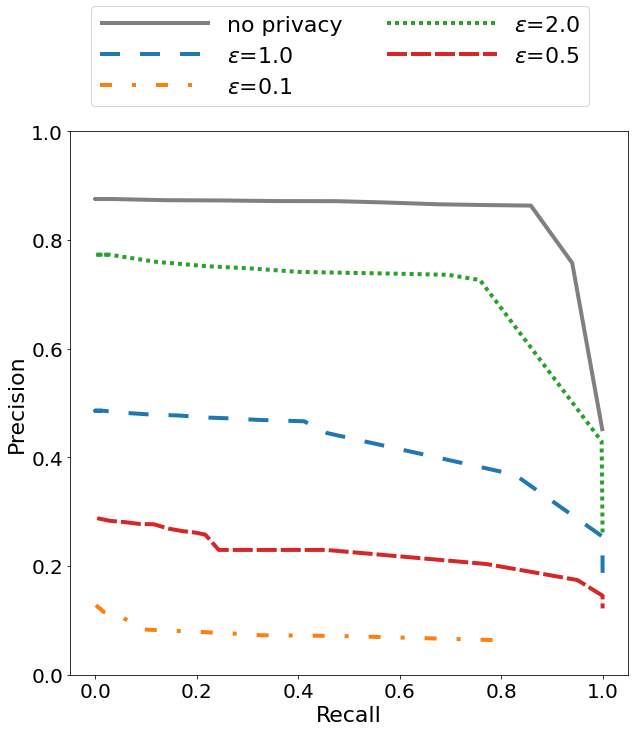

In [562]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_ylim(0,1)
# ax.set_xlim(0,1)
plot_precision_recall(res50, res_no_priv, ax, 50)

plt.show()

2451 & 567 & 334 & 221 & 4839 & 1071 & 604 & 378
g based on p95: 235.7561666666666 mins
Upper limit of uniform: 1.0: 604.170.1: 4838.982.0: 377.960.5: 1070.81
Expected Delays (B, U): 1.0: (334.06)0.1: (2451.46)2.0: (220.95)0.5: (567.37)
% Misordered: 1.0: 13.05 0.1: 17.72 2.0: 12.02 0.5: 14.24 


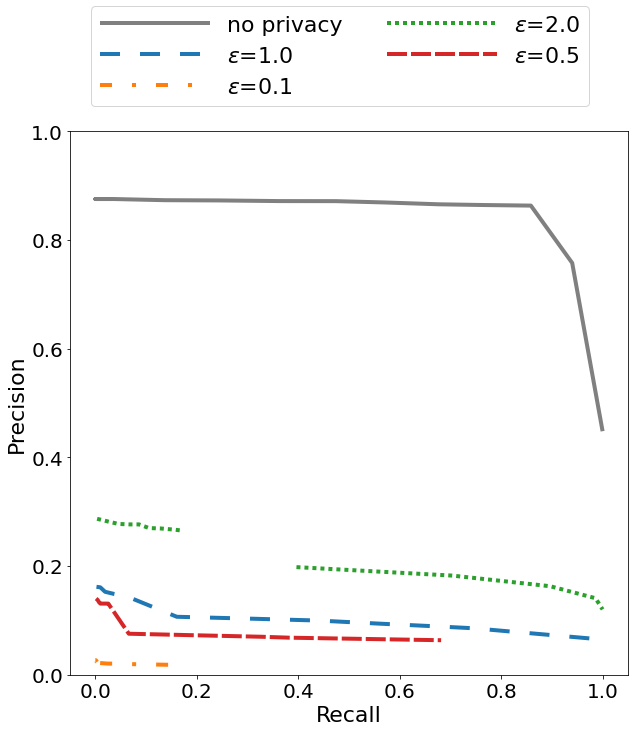

In [563]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_ylim(0,1)

plot_precision_recall(res95, res_no_priv, ax, 95)

plt.show()

In [564]:
1.0: (20.23)0.1: (118.2)2.0: (14.99)0.5: (31.02)
                
15,

SyntaxError: illegal target for annotation (2663015374.py, line 1)

In [565]:
sorted(res25[0.5][1])

[0.08356437238822798,
 0.13182270836001683,
 0.14880863011515716,
 0.17376935302231056,
 0.21244565815481362,
 0.2800667171250462,
 0.42785675718194704,
 0.634083262628699,
 0.6419164903362733,
 0.645161112177682,
 0.6467103965150134,
 0.6517903615400698,
 0.6588481585899166,
 0.6631627105790365,
 0.6674417677648675,
 0.6733518705909687,
 0.6806355744289658,
 0.6806355744289658]

118 & 31 & 20 & 15 & 229 & 54 & 33 & 22
g based on p25: 10.908333333333333 mins
Upper limit of uniform: 1.0: 32.720.1: 228.672.0: 22.260.5: 54.31
Expected Delays (B, U): 1.0: (20.23)0.1: (118.2)2.0: (14.99)0.5: (31.02)
% Misordered: 1.0: 6.79 0.1: 10.81 2.0: 6.54 0.5: 7.56 


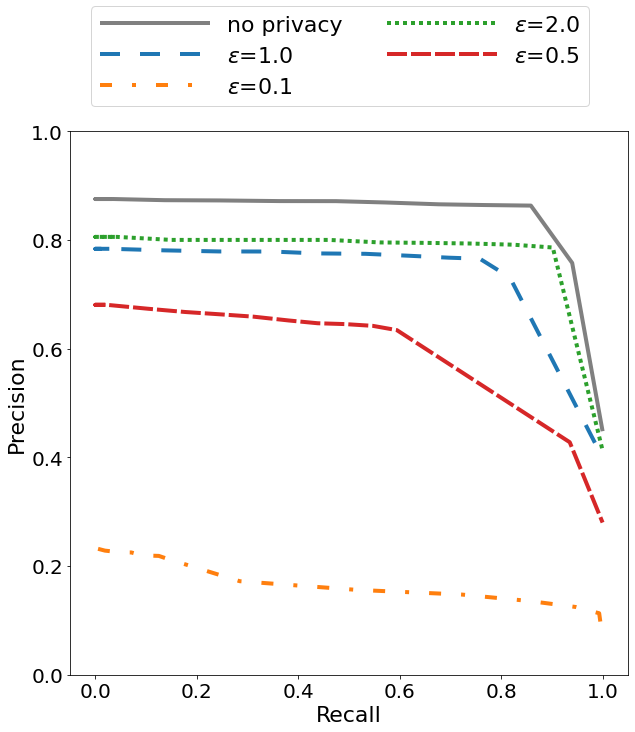

In [566]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_ylim(0,1)

plot_precision_recall(res25, res_no_priv, ax, 25)

plt.show()

820 & 192 & 115 & 77 & 1615 & 360 & 205 & 129
g based on p75: 78.53999999999999 mins
Upper limit of uniform: 1.0: 204.610.1: 1615.42.0: 129.250.5: 360.06
Expected Delays (B, U): 1.0: (114.62)0.1: (820.02)2.0: (76.94)0.5: (192.35)
% Misordered: 1.0: 11.3 0.1: 15.49 2.0: 10.16 0.5: 12.53 


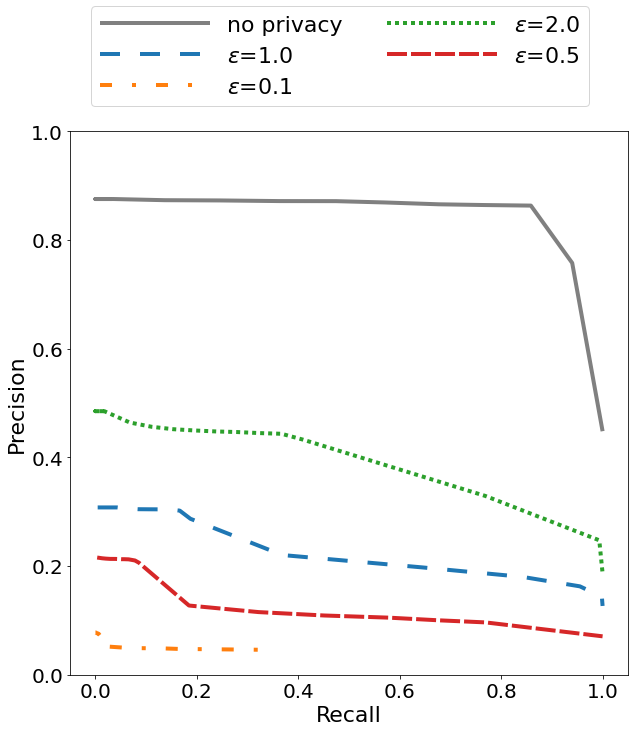

In [567]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_ylim(0,1)

plot_precision_recall(res75, res_no_priv, ax, 75)

plt.show()

In [505]:
df_cat_test.is_batched.mean()

0.25418783097373826